In [46]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import seaborn as sns
import geopandas as gpd

In [47]:
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

lat_min, lat_max = -26.25, -12 
lon_min, lon_max = 16, 32.25

mon_precip_zambia = mon_precip_sa.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

oct_precip_zambia = mon_precip_zambia.sel(date=(mon_precip_sa['date.month'] == 2))

mean_oct_precip_zambia = oct_precip_zambia.mean(dim=['latitude', 'longitude'])

oct_before_1980 = mean_oct_precip_zambia.sel(date=slice(None, '1980-10-01'))
oct_after_1980 = mean_oct_precip_zambia.sel(date=slice('1981-10-01', None))
print(oct_before_1980, oct_after_1980)

<xarray.Dataset> Size: 1kB
Dimensions:  (date: 41)
Coordinates:
    number   int64 8B ...
  * date     (date) datetime64[ns] 328B 1940-02-01 1941-02-01 ... 1980-02-01
    expver   (date) <U4 656B ...
Data variables:
    tp       (date) float32 164B 0.003618 0.003188 ... 0.004358 0.005338 <xarray.Dataset> Size: 1kB
Dimensions:  (date: 39)
Coordinates:
    number   int64 8B ...
  * date     (date) datetime64[ns] 312B 1982-02-01 1983-02-01 ... 2020-02-01
    expver   (date) <U4 624B ...
Data variables:
    tp       (date) float32 156B 0.004732 0.003104 0.00411 ... 0.004272 0.006747


In [48]:
precip_before = oct_before_1980['tp'].values  
precip_after = oct_after_1980['tp'].values

In [49]:
def bootstrap_sample(data, n_bootstraps):
    return np.random.choice(data, (n_bootstraps, len(data)), replace=True).mean(axis=1)

In [50]:
n_bootstraps = 10000

boot_means_before = bootstrap_sample(precip_before, n_bootstraps)
boot_means_after = bootstrap_sample(precip_after, n_bootstraps)

In [51]:

mean_before = np.mean(precip_before)
mean_after = np.mean(precip_after)
mean_diff = mean_before - mean_after

In [52]:
combined_means = np.concatenate((boot_means_before, boot_means_after))
p_value = np.mean(np.abs(boot_means_before.mean() - boot_means_after.mean()) >= np.abs(mean_diff))

In [53]:
print(f'Mean of Data before 1980: {mean_before}')
print(f'Mean of Data from 1980 onward: {mean_after}')
print(f'Bootstrap p-value: {p_value}')

Mean of Data before 1980: 0.005174657329916954
Mean of Data from 1980 onward: 0.004912916570901871
Bootstrap p-value: 1.0


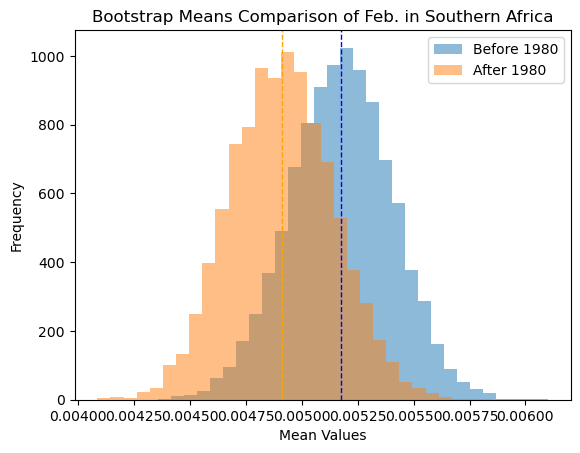

In [54]:
plt.hist(boot_means_before, alpha=0.5, label='Before 1980', bins=30)
plt.hist(boot_means_after, alpha=0.5, label='After 1980', bins=30)
plt.axvline(mean_before, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_after, color='orange', linestyle='dashed', linewidth=1)
plt.legend()
plt.title('Bootstrap Means Comparison of Feb. in Southern Africa')
plt.xlabel('Mean Values')
plt.ylabel('Frequency')

#plt.savefig('/home/k16v981/my_work/figures/southern_africa/oct_bs_precip.jpg', format='jpg')

plt.show()